In [1]:
import json
import numpy
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
from gluoncv import model_zoo, data, utils
import random
import sys
import cv2

from data_aug.data_aug import *
from data_aug.bbox_util import *

In [3]:
inst_train_path = "/home/ubuntu/data/annotations/instances_train2017.json"
inst_train  = json.loads(open(inst_train_path).read())
inst_train.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [4]:
captions_train_path = "/home/ubuntu/data/annotations/captions_train2017.json"
captions_val_path = "/home/ubuntu/data/annotations/captions_val2017.json"
inst_train_path = "/home/ubuntu/data/annotations/instances_train2017.json"
inst_val_path = "/home/ubuntu/data/annotations/instances_val2017.json"

In [5]:
def merge_image_info(captions_path, inst_path):
    captions  = json.loads(open(captions_path).read())
    inst  = json.loads(open(inst_path).read())
    image_df = pd.DataFrame(inst['images'])
    annotation_df = pd.DataFrame(inst['annotations'])
    #the 'id' in image_df needs to be changed to 'image_id' in order to join with annotations_df
    renamed_image_df = image_df.copy(deep=True)
    renamed_image_df.rename(columns={'id':'image_id'}, inplace=True)
    images_and_annotations_df = annotation_df.merge(renamed_image_df,on='image_id', how='left')
    #electronics_only_merged_df = images_and_annotations_df.loc[(images_and_annotations_df['category_id'] >= 72) & (images_and_annotations_df['category_id'] <= 77)]
    
    #select all images that contain electronics
    #all_images_with_electronics = list(pd.Series(electronics_only_merged_df['image_id']).unique())
    
    #return(electronics_only_merged_df)
    return(images_and_annotations_df)

In [47]:
def write_line(img_path, im_shape, boxes, ids, idx):
    h, w, c = im_shape
    # for header, we use minimal length 2, plus width and height
    # with A: 4, B: 5, C: width, D: height
    A = 4
    B = 5
    C = w
    D = h
    # concat id and bboxes
    labels = np.hstack((ids.reshape(-1, 1), boxes)).astype('float')
    # normalized bboxes (recommanded)
    labels[:, (1, 3)] /= float(w)
    labels[:, (2, 4)] /= float(h)
    # flatten
    labels = labels.flatten().tolist()
    str_idx = [str(idx)]
    str_header = [str(x) for x in [A, B, C, D]]
    str_labels = [str(x) for x in labels]
    str_path = [img_path]
    line = '\t'.join(str_idx + str_header + str_labels + str_path) + '\n'
    return line

In [6]:
train_info = merge_image_info(captions_train_path, inst_train_path)
val_info = merge_image_info(captions_val_path, inst_val_path)

In [9]:
train_info.head()#add in actual label name

,area,bbox,category_id,id,image_id,iscrowd,segmentation,coco_url,date_captured,file_name,flickr_url,height,license,width
0,2765.14865,"[199.84, 200.46, 77.71, 70.88]",58,156,558840,0,"[[239.97, 260.24, 222.04, 270.49, 199.84, 253....",http://images.cocodataset.org/train2017/000000...,2013-11-15 06:55:40,000000558840.jpg,http://farm5.staticflickr.com/4045/4488509035_...,427,1,640
1,1545.42130,"[234.22, 317.11, 149.39, 38.55]",58,509,200365,0,"[[247.71, 354.7, 253.49, 346.99, 276.63, 337.3...",http://images.cocodataset.org/train2017/000000...,2013-11-15 00:04:50,000000200365.jpg,http://farm2.staticflickr.com/1177/1162747961_...,480,3,640
2,5607.66135,"[239.48, 347.87, 160.0, 57.81]",58,603,200365,0,"[[274.58, 405.68, 298.32, 405.68, 302.45, 402....",http://images.cocodataset.org/train2017/000000...,2013-11-15 00:04:50,000000200365.jpg,http://farm2.staticflickr.com/1177/1162747961_...,480,3,640
3,0.00000,"[296.65, 388.33, 1.03, 0.0]",58,918,200365,0,"[[296.65, 388.33, 296.65, 388.33, 297.68, 388....",http://images.cocodataset.org/train2017/000000...,2013-11-15 00:04:50,000000200365.jpg,http://farm2.staticflickr.com/1177/1162747961_...,480,3,640
4,800.41325,"[251.87, 333.42, 125.94, 22.71]",58,1072,200365,0,"[[251.87, 356.13, 260.13, 343.74, 300.39, 335....",http://images.cocodataset.org/train2017/000000...,2013-11-15 00:04:50,000000200365.jpg,http://farm2.staticflickr.com/1177/1162747961_...,480,3,640


In [10]:
#get list of image_ids
image_list = train_info['image_id'].unique()
list(image_list)[:10]

[558840, 200365, 495357, 116061, 16164, 205350, 74, 212545, 514915, 154589]

In [11]:
test_image_info = train_info[train_info['image_id']==558840]

In [13]:
for blah in range(1):
    print(blah)

0


In [15]:
train_info.loc[0,:]

area                                                       2765.15
bbox                                [199.84, 200.46, 77.71, 70.88]
category_id                                                     58
id                                                             156
image_id                                                    558840
iscrowd                                                          0
segmentation     [[239.97, 260.24, 222.04, 270.49, 199.84, 253....
coco_url         http://images.cocodataset.org/train2017/000000...
date_captured                                  2013-11-15 06:55:40
file_name                                         000000558840.jpg
flickr_url       http://farm5.staticflickr.com/4045/4488509035_...
height                                                         427
license                                                          1
width                                                          640
Name: 0, dtype: object

In [16]:
train_info.loc[0,:]['image_id']

558840

In [13]:
train_folder_name = '/home/ubuntu/data/train2017/'
all_train_filenames = os.listdir(train_folder_name)
max_file_id_length = len(all_train_filenames[0]) - 4

In [19]:
files_to_open = []
for image_id in train_info['image_id']:
    file_id = str(image_id)
    zeros_to_add = max_file_id_length-len(file_id)
    filename = ('0'*zeros_to_add) + file_id + '.jpg'
    files_to_open.append(filename)

In [24]:
file_name = train_folder_name + files_to_open[0]

In [28]:
file_name

'/home/ubuntu/data/train2017/000000558840.jpg'

In [14]:
file_name = train_folder_name + '000000' + str(train_info.loc[0,:]['image_id']) + '.jpg'
file_name

'/home/ubuntu/data/train2017/000000558840.jpg'

In [15]:
x, img = data.transforms.presets.ssd.load_test(file_name, short=512)

In [16]:
x.shape

(1, 3, 512, 767)

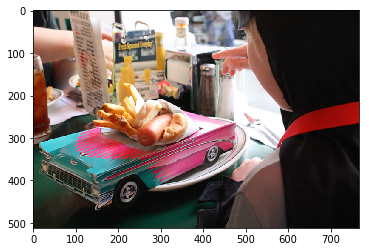

In [17]:
ax = utils.viz.plot_image(img)
plt.show()

In [20]:
test_image_info.index

Int64Index([0, 6947, 7027, 9476, 14835, 17418, 18551, 21311, 23358, 24876,
            28515],
           dtype='int64')

In [40]:
#get bboxes
bboxes = []
for idx in test_image_info.index:
    b_box = test_image_info.loc[idx,:]['bbox'].copy()
    b_box_class = test_image_info.loc[idx,:]['category_id']
    b_box.append(b_box_class)
    bboxes.append(np.array(b_box))
    #print(test_image_info.loc[idx,:])
bboxes = np.array(bboxes)
bboxes

array([[199.84, 200.46,  77.71,  70.88,  58.  ],
       [325.27, 104.38,  33.67, 105.99,  44.  ],
       [168.85,  90.98,  31.42,  88.73,  44.  ],
       [  1.92,  87.91,  34.95, 175.35,  47.  ],
       [346.58,   1.07, 292.01, 343.71,   1.  ],
       [239.08,  42.72,  19.88,  76.73,  44.  ],
       [409.93, 215.42,  71.84,  50.12,  50.  ],
       [  0.96,   1.02,  93.08, 160.25,   1.  ],
       [276.39,  13.81,  31.75,  61.57,  44.  ],
       [  3.33, 263.96, 359.34, 156.39,  67.  ],
       [413.54, 201.9 ,  72.79,  56.38,  50.  ]])

In [48]:
#get bboxes
bboxes2 = []
for idx in test_image_info.index:
    b_box = test_image_info.loc[idx,:]['bbox'].copy()
    #b_box_class = test_image_info.loc[idx,:]['category_id']
    #b_box.append(b_box_class)
    bboxes2.append(np.array(b_box))
    #print(test_image_info.loc[idx,:])
bboxes2 = np.array(bboxes2)
bboxes2

array([[199.84, 200.46,  77.71,  70.88],
       [325.27, 104.38,  33.67, 105.99],
       [168.85,  90.98,  31.42,  88.73],
       [  1.92,  87.91,  34.95, 175.35],
       [346.58,   1.07, 292.01, 343.71],
       [239.08,  42.72,  19.88,  76.73],
       [409.93, 215.42,  71.84,  50.12],
       [  0.96,   1.02,  93.08, 160.25],
       [276.39,  13.81,  31.75,  61.57],
       [  3.33, 263.96, 359.34, 156.39],
       [413.54, 201.9 ,  72.79,  56.38]])

In [48]:
b_box_test = train_info.loc[0,:]['bbox'].copy()
b_box_test

[199.84, 200.46, 77.71, 70.88]

In [43]:
bbox_class = train_info.loc[0,:]['category_id']

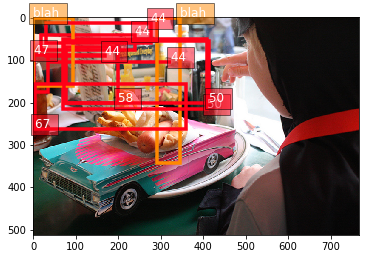

In [36]:
ax = utils.viz.plot_bbox(img, np.array(bboxes), labels=np.array(test_image_info['category_id']), class_names=['blah']*len(bboxes))
plt.show()

In [ ]:
#current b_box format: [xmin, ymin, xmax, ymax]
#need to convert bbox format to [top left x, top left y, bottom right x, bottom right y, class]
#want [xmin, ymax, xmax, ymin]

In [38]:
img = cv2.imread(file_name)[:,:,::-1]
#bboxes = np.array([b_box_test])
print(bboxes)

[array([199.84, 200.46,  77.71,  70.88,  58.  ]), array([325.27, 104.38,  33.67, 105.99,  44.  ]), array([168.85,  90.98,  31.42,  88.73,  44.  ]), array([  1.92,  87.91,  34.95, 175.35,  47.  ]), array([346.58,   1.07, 292.01, 343.71,   1.  ]), array([239.08,  42.72,  19.88,  76.73,  44.  ]), array([409.93, 215.42,  71.84,  50.12,  50.  ]), array([  0.96,   1.02,  93.08, 160.25,   1.  ]), array([276.39,  13.81,  31.75,  61.57,  44.  ]), array([  3.33, 263.96, 359.34, 156.39,  67.  ]), array([413.54, 201.9 ,  72.79,  56.38,  50.  ])]


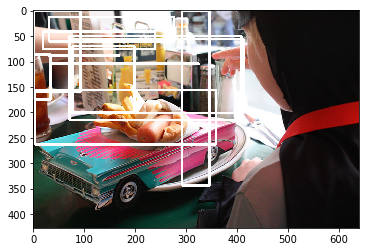

In [41]:
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

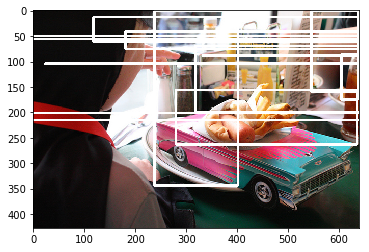

In [42]:
img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

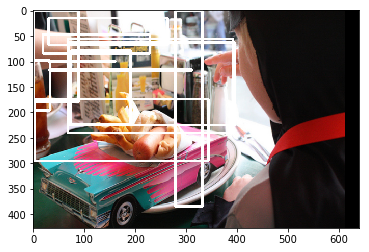

In [43]:
img_, bboxes_ = RandomScale(0.3, diff = True)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

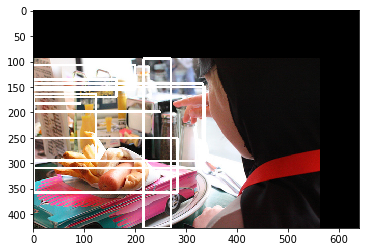

In [44]:
img_, bboxes_ = RandomTranslate(0.3, diff = True)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

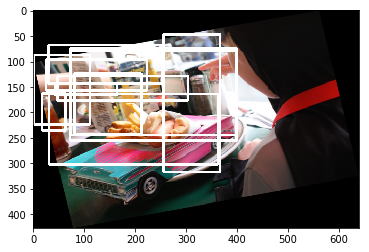

In [45]:
img_, bboxes_ = RandomRotate(20)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

In [49]:
#cv2.imwrite('/home/ubuntu/data/train2017/augmentations/'+, img_)
img_path = '/home/ubuntu/'+str(558840)+'_aug1.jpg'
cv2.imwrite(img_path, img_)

True

In [50]:
write_line(img_path, img_.shape, bboxes2, np.array(test_image_info['category_id']), 0)

'0\t4\t5\t640\t427\t58.0\t0.31225\t0.46946135831381736\t0.12142187499999998\t0.16599531615925056\t44.0\t0.508234375\t0.24444964871194377\t0.052609375\t0.24822014051522248\t44.0\t0.26382812499999997\t0.21306791569086653\t0.049093750000000005\t0.2077985948477752\t47.0\t0.003\t0.2058782201405152\t0.054609375\t0.41065573770491803\t1.0\t0.54153125\t0.0025058548009367684\t0.456265625\t0.8049414519906323\t44.0\t0.3735625\t0.10004683840749415\t0.0310625\t0.17969555035128806\t50.0\t0.640515625\t0.504496487119438\t0.11225\t0.11737704918032786\t1.0\t0.0015\t0.002388758782201405\t0.1454375\t0.3752927400468384\t44.0\t0.431859375\t0.03234192037470726\t0.049609375\t0.144192037470726\t67.0\t0.005203125\t0.6181733021077283\t0.56146875\t0.36625292740046833\t50.0\t0.64615625\t0.4728337236533958\t0.11373437500000001\t0.1320374707259953\t/home/ubuntu/558840_aug1.jpg\n'

In [51]:
with open('/home/ubuntu/test.lst', 'w') as fw:
    for i in range(1):
        line = write_line(img_path, img_.shape, bboxes2, np.array(test_image_info['category_id']), i)
        print(line)
        fw.write(line)

0	4	5	640	427	58.0	0.31225	0.46946135831381736	0.12142187499999998	0.16599531615925056	44.0	0.508234375	0.24444964871194377	0.052609375	0.24822014051522248	44.0	0.26382812499999997	0.21306791569086653	0.049093750000000005	0.2077985948477752	47.0	0.003	0.2058782201405152	0.054609375	0.41065573770491803	1.0	0.54153125	0.0025058548009367684	0.456265625	0.8049414519906323	44.0	0.3735625	0.10004683840749415	0.0310625	0.17969555035128806	50.0	0.640515625	0.504496487119438	0.11225	0.11737704918032786	1.0	0.0015	0.002388758782201405	0.1454375	0.3752927400468384	44.0	0.431859375	0.03234192037470726	0.049609375	0.144192037470726	67.0	0.005203125	0.6181733021077283	0.56146875	0.36625292740046833	50.0	0.64615625	0.4728337236533958	0.11373437500000001	0.1320374707259953	/home/ubuntu/558840_aug1.jpg



In [53]:
with open('/home/ubuntu/test.lst', 'rb') as fw:
    print(fw.read())

b'0\t4\t5\t640\t427\t58.0\t0.31225\t0.46946135831381736\t0.12142187499999998\t0.16599531615925056\t44.0\t0.508234375\t0.24444964871194377\t0.052609375\t0.24822014051522248\t44.0\t0.26382812499999997\t0.21306791569086653\t0.049093750000000005\t0.2077985948477752\t47.0\t0.003\t0.2058782201405152\t0.054609375\t0.41065573770491803\t1.0\t0.54153125\t0.0025058548009367684\t0.456265625\t0.8049414519906323\t44.0\t0.3735625\t0.10004683840749415\t0.0310625\t0.17969555035128806\t50.0\t0.640515625\t0.504496487119438\t0.11225\t0.11737704918032786\t1.0\t0.0015\t0.002388758782201405\t0.1454375\t0.3752927400468384\t44.0\t0.431859375\t0.03234192037470726\t0.049609375\t0.144192037470726\t67.0\t0.005203125\t0.6181733021077283\t0.56146875\t0.36625292740046833\t50.0\t0.64615625\t0.4728337236533958\t0.11373437500000001\t0.1320374707259953\t/home/ubuntu/558840_aug1.jpg\n'


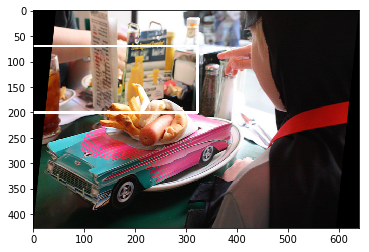

In [57]:
img_, bboxes_ = RandomShear(0.2)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

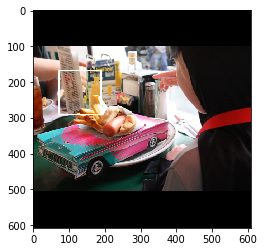

In [58]:
img_, bboxes_ = Resize(608)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

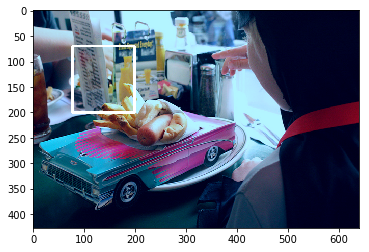

In [59]:
img_, bboxes_ = RandomHSV(100, 100, 100)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

In [62]:
cv2.imwrite('/home/ubuntu/test_save.jpg', img_)

True

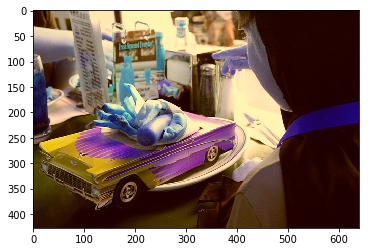

In [63]:
img = cv2.imread('/home/ubuntu/test_save.jpg')[:,:,::-1]
plt.imshow(img)
plt.show()